In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

api_key = os.getenv('GROQ_API_KEY')

In [2]:
from groq import Client

client = Client(api_key=api_key)

In [3]:
def prompt_template(content):
    return [{"role": "user", "content": content}]

In [4]:
from metric_prompts.faithfulness import faithfulness_prompt
from metric_prompts.answer_relevancy import answer_relevancy_prompt
from ratelimit import limits, sleep_and_retry

RATE_LIMIT = 30
TIME_PERIOD = 180

@sleep_and_retry
@limits(calls=RATE_LIMIT, period=TIME_PERIOD)
def api_call(client, message, model):
    response = client.chat.completions.create(messages=message, model=model)
    return response.choices[0].message.content


def faithfulness(judge, query, context, output):
    judge_statement = judge.chat.completions.create(
        messages=prompt_template(faithfulness_prompt(context, query, output)),
        model="llama3-70b-8192",
        temperature=0.2,
    )
    return judge_statement.choices[0].message.content

def answer_relevancy(judge, query, output):
    judge_statement = judge.chat.completions.create(
        messages=prompt_template(answer_relevancy_prompt(query, output)),
        model="llama3-70b-8192",
        temperature=0.2,
    )
    return judge_statement.choices[0].message.content

In [5]:
import pandas as pd
df = pd.read_parquet("../RAGtruth/data.parquet")
df = df[df["task_type"] == "QA"]

df["labels"] = df["labels"].apply(lambda x: False if len(x) == 0 else x)
df["labels"] = df["labels"].apply(lambda x: x[0]["label_type"] if type(x) != bool else x)

# Filter rows where labels are not False
positive = df[df["labels"] != False]

def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks
chunks_l = split_dataframe(positive, chunk_size=100)

In [6]:
chunks = split_dataframe(df, chunk_size=100)

In [7]:
label_mapping = {label: idx for idx, label in enumerate(df["labels"].unique())}
df["labels"] = df["labels"].map(label_mapping)

In [9]:
import json
from tqdm import tqdm
import numpy as np

STEP = 25
BATCH_SIZE = 4


for b in range(1, 4):
    faithful_values = []
    ar_values = []
    temperature_values = []
    ys = []
    for i, (source_id, group) in enumerate(tqdm(df.groupby(df.index))):
        if i > 50:
            break
        questions = group["question"].values[0]
        context = group["context"].values[0]
        responses = group["response"].values.tolist()
        temperatures = group["temperature"].values.tolist()
        labels = group["labels"].values.tolist()

        raw_json = faithfulness(client, questions, context, responses)
        raw_json = raw_json[raw_json.find("{") : raw_json.rfind("}") + 1]
        try:
            parsed_json = json.loads(raw_json)
        except json.JSONDecodeError:
            print(raw_json)
            faithful_values.extend([None for _ in range(len(group))])
        else:
            faithful_values.extend(
                [parsed_json[f"answer_{j}"]["faithfulness"] for j in range(len(group))]
            )
        finally:
            raw_json = answer_relevancy(client, questions, responses)
            raw_json = raw_json[raw_json.find("{") : raw_json.rfind("}") + 1]
            try:
                parsed_json = json.loads(raw_json)

            except json.JSONDecodeError:
                print(raw_json)
                ar_values.extend([None for _ in range(len(group))])
            else:
                ar_values.extend(
                    [parsed_json[f"answer_{j}"]["answer_relevancy"] for j in range(len(group))]
                )
            finally:
                temperature_values.extend(temperatures)
                ys.extend(labels)
                if i % STEP == 0 and i > 0:
                    print(f"Length of ar_values: {len(ar_values)}")
                    print(f"Length of faithful_values: {len(faithful_values)}")
                    print(f"Length of temperature_values: {len(temperature_values)}")
                    print(f"Length of ys: {len(ys)}")
                    pd.DataFrame.from_dict(
                        {
                            "faithfulness": faithful_values,
                            "answer_relevancy": ar_values,
                            "temperature": temperatures,
                            "label": ys,
                        }, orient="index"
                    ).T.to_parquet(f"data_{i // STEP - 1}_{b}.parquet")

  0%|          | 0/989 [00:00<?, ?it/s]


BadRequestError: Error code: 400 - {'error': {'message': 'Organization has been restricted. Please reach out to support if you believe this was in error.', 'type': 'invalid_request_error', 'code': 'organization_restricted'}}

## Loading RAGTruth

In [4]:
def roBERTa_prompt(question, answer, context):
    return f"Based on the question {question}, and the {context}, determine whether the {answer} hallucinates"

In [2]:
from transformers import RobertaTokenizer
from torch.utils.data import Dataset, DataLoader

class RAGTruthDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

In [11]:
df["roBERTa"] = df.apply(lambda x: roBERTa_prompt(x["question"], x["response"], x["context"]), axis=1)
y = df["labels"]
label_mapping = {label: idx for idx, label in enumerate(y.unique())}
y = y.map(label_mapping)

In [13]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")


dataset = RAGTruthDataset(df["roBERTa"].to_numpy(), y.to_numpy(), tokenizer, max_length=128)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [6]:
from transformers import RobertaForSequenceClassification
from torch.optim import AdamW
from transformers import get_scheduler

num_labels = len(np.unique(y))
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)

optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(dataloader) * num_epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

,task_type,source,prompt,id,model,temperature,labels,split,quality,response,question,context
source_id,,,,,,,,,,,,
14292,QA,MARCO,Briefly answer the following question:\nbutche...,11856,gpt-4-0613,0.70,False,train,good,The phone numbers for several butcher shops ar...,butcher shop phone number,"passage 1:Butcher Shop - Hayward 826 B Street,..."
14292,QA,MARCO,Briefly answer the following question:\nbutche...,11857,gpt-3.5-turbo-0613,0.70,False,train,good,Butcher Shop - Hayward phone number: (510) 889...,butcher shop phone number,"passage 1:Butcher Shop - Hayward 826 B Street,..."
14292,QA,MARCO,Briefly answer the following question:\nbutche...,11858,mistral-7B-instruct,0.70,Evident Baseless Info,train,good,"Based on the given passages, there are several...",butcher shop phone number,"passage 1:Butcher Shop - Hayward 826 B Street,..."
14292,QA,MARCO,Briefly answer the following question:\nbutche...,11859,llama-2-7b-chat,0.85,False,train,good,"Based on the provided passages, the butcher sh...",butcher shop phone number,"passage 1:Butcher Shop - Hayward 826 B Street,..."
14292,QA,MARCO,Briefly answer the following question:\nbutche...,11860,llama-2-13b-chat,0.70,False,train,good,"Based on the given passages, the butcher shop ...",butcher shop phone number,"passage 1:Butcher Shop - Hayward 826 B Street,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
12460,QA,MARCO,Briefly answer the following question:\nwhat a...,17785,gpt-3.5-turbo-0613,0.70,False,train,good,Eating tomatoes can provide nutrition benefits...,what are nutrition benefits eating tomatoes,passage 1:2. Prevent DNA Damage. Tomatoes are ...
12460,QA,MARCO,Briefly answer the following question:\nwhat a...,17786,mistral-7B-instruct,0.70,Evident Baseless Info,train,good,"Based on the given passages, it appears that e...",what are nutrition benefits eating tomatoes,passage 1:2. Prevent DNA Damage. Tomatoes are ...
12460,QA,MARCO,Briefly answer the following question:\nwhat a...,17787,llama-2-7b-chat,0.70,Evident Baseless Info,train,good,"Based on the provided passages, here are the n...",what are nutrition benefits eating tomatoes,passage 1:2. Prevent DNA Damage. Tomatoes are ...


In [ ]:
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

num_epochs = 3
loss_fn = CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    loop = tqdm(dataloader, leave=True)
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

In [ ]:
model.save_pretrained("fine_tuned_roberta")
tokenizer.save_pretrained("fine_tuned_roberta")

# Evaluate
model.eval()

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Load the fine-tuned model and tokenizer
model_path = "fine_tuned_roberta"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)

# Move model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

In [ ]:
def preprocess_text(text, tokenizer, max_length=128):
    encoding = tokenizer(
        text,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    return encoding

In [ ]:
import torch

def predict(text, model, tokenizer, max_length=128):
    # Preprocess the text
    encoding = preprocess_text(text, tokenizer, max_length)

    # Move tensors to device
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    # Get logits and convert to probabilities
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)

    # Get the predicted class
    predicted_class = torch.argmax(probabilities, dim=-1).item()

    return predicted_class, probabilities.cpu().numpy()

# Example usage
text = "This is a sample text for inference."
predicted_class, probabilities = predict(text, model, tokenizer)

print(f"Predicted class: {predicted_class}")
print(f"Probabilities: {probabilities}")

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [44]:
import torch.nn as nn
import torch.nn.functional as F

class BasicMLP(nn.Module):
    def __init__(self):
        super(BasicMLP, self).__init__()
        self.ffnn = nn.Sequential(
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Linear(2, len(index)),
        )
    def forward(self, x):
        return self.ffnn(x)

In [31]:
import torch.optim as optim

model = BasicMLP()
optimizer = optim.Adam(model.parameters(),)
loss_fn = nn.CrossEntropyLoss()

In [45]:
from torch.utils.data import TensorDataset, DataLoader
import torch

x_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32, requires_grad=True)
y_tensor = torch.tensor(y_train, dtype=torch.long)

# Create a TensorDataset
dataset = TensorDataset(x_tensor, y_tensor)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [46]:
EPOCHS = 100

for epoch in range(EPOCHS):
    running_loss = 0.
    last_loss = 0.

    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 5 == 0:
        print('EPOCH {}:'.format(epoch + 1))
        print(running_loss)

EPOCH 1:
3.11735337972641
EPOCH 6:
3.1196709871292114
EPOCH 11:
3.215919852256775
EPOCH 16:
3.586550533771515
EPOCH 21:
3.2034358978271484
EPOCH 26:
3.355764091014862
EPOCH 31:
3.2376062870025635
EPOCH 36:
3.7988849878311157
EPOCH 41:
3.2641862630844116
EPOCH 46:
2.888943374156952
EPOCH 51:
2.7804263830184937
EPOCH 56:
3.0602681040763855
EPOCH 61:
3.324139714241028
EPOCH 66:
3.0205820202827454
EPOCH 71:
2.8311057686805725
EPOCH 76:
3.3463022708892822
EPOCH 81:
3.1722772121429443
EPOCH 86:
2.8814147114753723
EPOCH 91:
2.77474308013916
EPOCH 96:
3.1973016262054443


In [52]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(penalty='l2')

log.fit(X_train, y_train)

LogisticRegression()

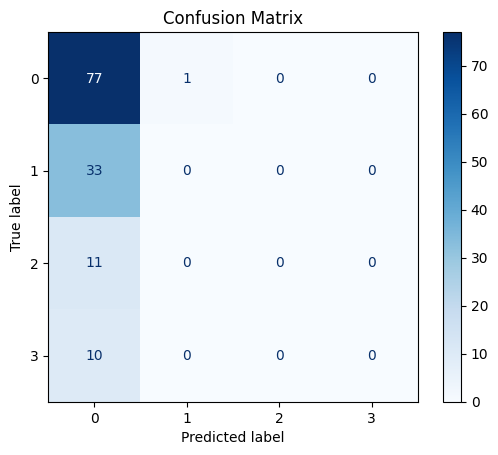

In [53]:
cm = confusion_matrix(y_test, log.predict(X_test))

# Display confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")

plt.show()

In [47]:
x_tensor_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_tensor_test = torch.tensor(y_test, dtype=torch.long)
dataset = TensorDataset(x_tensor_test, y_tensor_test)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [48]:
with torch.no_grad():
    running_vloss = 0.
    avg_loss = 0.
    for i, vdata in enumerate(test_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
    
        avg_vloss = running_vloss / (i + 1)

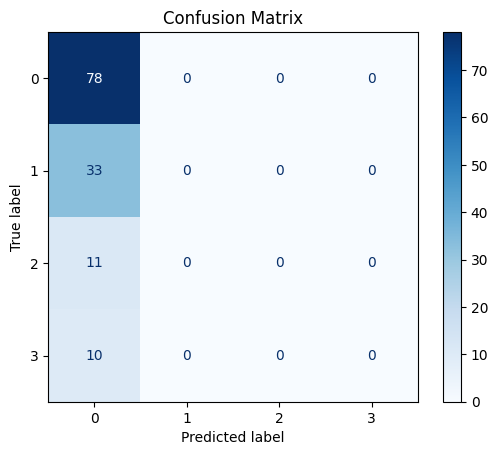

In [49]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels = []
predicted_labels = []

# Set model to evaluation mode
model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        # Get model outputs
        outputs = model(inputs)  # Raw logits
        
        # Apply sigmoid activation
        probabilities = torch.sigmoid(outputs)
        
        # Compute argmax for class prediction
        predictions = torch.argmax(probabilities, dim=1)
        
        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("dl.png")
plt.show()

## Completeness

In [ ]:
completeness = (
    judge.chat_completion(
        completeness_prompt(output, inputs["question"], inputs["context"]),
        max_tokens=300,
    )
    .choices[0]
    .message.content.lower()
)
completeness_val = int(completeness.split('"completeness": ')[-1][0]) / 5
completeness_val, completeness

In [ ]:
context_relevance = list(
    filter(
        None,
        judge.chat_completion(
            context_statements(inputs["context"], inputs["question"]), max_tokens=400
        )
        .choices[0]
        .message.content.lower()
        .split("statement:"),
    )
)
context_summarized = list(
    filter(
        None,
        judge.chat_completion(summarize_context(inputs["context"]), max_tokens=1000)
        .choices[0]
        .message.content.lower()
        .split("statement:"),
    )
)

In [ ]:
len(context_relevance) / summarized_length(judge, inputs["context"])

In [ ]:
context_relevance